In [136]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport

def sum_over(*args):
    return sum(args)

In [138]:
#import packages for the problem formulation and the dike_model_simulation.py for reference scenario sampling
from __future__ import (unicode_literals, print_function, absolute_import,division)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench import ScalarOutcome
from problem_formulation import get_model_for_problem_formulation

import time

ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(3)

In [139]:
#for unc in dike_model.uncertainties:
#    print(repr(unc))
    
uncertainties = dike_model.uncertainties

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)

In [140]:
for policy in dike_model.levers:
    print(repr(policy))
levers = dike_model.levers 
import copy
levers = copy.deepcopy(dike_model.levers)


IntegerParameter('0_RfR 0', 0, 1)
IntegerParameter('0_RfR 1', 0, 1)
IntegerParameter('0_RfR 2', 0, 1)
IntegerParameter('1_RfR 0', 0, 1)
IntegerParameter('1_RfR 1', 0, 1)
IntegerParameter('1_RfR 2', 0, 1)
IntegerParameter('2_RfR 0', 0, 1)
IntegerParameter('2_RfR 1', 0, 1)
IntegerParameter('2_RfR 2', 0, 1)
IntegerParameter('3_RfR 0', 0, 1)
IntegerParameter('3_RfR 1', 0, 1)
IntegerParameter('3_RfR 2', 0, 1)
IntegerParameter('4_RfR 0', 0, 1)
IntegerParameter('4_RfR 1', 0, 1)
IntegerParameter('4_RfR 2', 0, 1)
IntegerParameter('EWS_DaysToThreat', 0, 4)
IntegerParameter('A.1_DikeIncrease 0', 0, 10)
IntegerParameter('A.1_DikeIncrease 1', 0, 10)
IntegerParameter('A.1_DikeIncrease 2', 0, 10)
IntegerParameter('A.2_DikeIncrease 0', 0, 10)
IntegerParameter('A.2_DikeIncrease 1', 0, 10)
IntegerParameter('A.2_DikeIncrease 2', 0, 10)
IntegerParameter('A.3_DikeIncrease 0', 0, 10)
IntegerParameter('A.3_DikeIncrease 1', 0, 10)
IntegerParameter('A.3_DikeIncrease 2', 0, 10)
IntegerParameter('A.4_DikeIncreas

In [141]:
#for outcome in dike_model.outcomes:
#    print(repr(outcome))

In [142]:
#this is the standard (old) problem formulation --> needs to be updated to the version of Erik
def problem_formulation_actor(problem_formulation_actor):  
    # Load the model:
    function = DikeNetwork()
    # workbench model:
    model = Model('dikesnet', function=function)
    # Outcomes are all costs, thus they have to minimized:
    direction = ScalarOutcome.MINIMIZE
    
    model.uncertainties = uncertainties
    model.levers = levers

    if problem_formulation_actor == 4: # RWS
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome('Expected Annual Damage',
                            variable_name=['{}_Expected Annual Damage {}'.format(dike, steps) for dike in function.dikelist for steps in function.planning_steps],
                            function=sum_over, kind=direction),

            ScalarOutcome('Total Investment Costs',
                            variable_name=['{}_Dike Investment Costs {}'.format(dike, steps) for dike in function.dikelist for steps in function.planning_steps]+
                          ['RfR Total Costs {}'.format(steps) for steps in function.planning_steps]+
                          ['Expected Evacuation Costs {}'.format(steps) for steps in function.planning_steps],
                            function=sum_over, kind=direction),

            ScalarOutcome('Expected Number of Deaths',
                            variable_name=['{}_Expected Number of Deaths {}'.format(dike, steps) for dike in function.dikelist for steps in function.planning_steps],
                            function=sum_over, kind=direction)] 
    
    elif problem_formulation_actor == 5: # GELDERLAND
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome('Expected Annual Damage A1-4',
                            variable_name=['{}_Expected Annual Damage {}'.format(dike, steps) for dike in function.dikelist[:-1] for steps in function.planning_steps], 
                          function=sum_over, kind=direction),

            ScalarOutcome('Investment Costs A1-4',
                            variable_name=['{}_Dike Investment Costs {}'.format(dike, steps) for dike in function.dikelist[:-1] for steps in function.planning_steps], 
                          function=sum_over, kind=direction),

            ScalarOutcome('Expected Number of Deaths in A1-4',
                            variable_name=['{}_Expected Number of Deaths {}'.format(dike, steps) for dike in function.dikelist[:-1] for steps in function.planning_steps],
                          function=sum_over, kind=direction)]

    elif problem_formulation_actor == 6: # OVERIJSSEL
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome('Expected Annual Damage A5', variable_name=['A.5_Expected Annual Damage {}'.format(steps) for steps in function.planning_steps], function=sum_over, kind=direction),

            ScalarOutcome('Investment Costs A5', variable_name=['A.5_Dike Investment Costs {}'.format(steps) for steps in function.planning_steps], function=sum_over, kind=direction),

            ScalarOutcome('Expected Number of Deaths in A5', variable_name=['A.5_Expected Number of Deaths {}'.format(steps) for steps in function.planning_steps], function=sum_over, kind=direction)]
    
    else:
        raise TypeError('unknown identifier')
    return model


In [143]:
#within here, we can generate user defined reference scenarios to draw a lot of policies from
#We sample 1000 policies over the reference scenario for a first exploration of the effect of certain policies combinations

# This code is a copy of dike_model_simulation.py -

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    dike_model, planning_steps = get_model_for_problem_formulation(2)

    # Build a user-defined scenario and policy:
    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'ID flood wave shape': 4, 'planning steps': 2}
    reference_values.update({'discount rate {}'.format(n): 3.5 for n in planning_steps})
    scen1 = {}

    for key in dike_model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)

    # no dike increase, no warning, none of the rfr
    zero_policy = {'DaysToThreat': 0}
    zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
    zero_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})
    pol0 = {}

    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy('Policy 0', **pol0)

    # Call random scenarios or policies:
#    n_scenarios = 5
#    scenarios = sample_uncertainties(dike_model, 50)
#    n_policies = 10

    # single run
#    start = time.time()
#    dike_model.run_model(ref_scenario, policy0)
#    end = time.time()
#    print(end - start)
#    results = dike_model.outcomes_output

    # series run
    #experiments, outcomes = perform_experiments(dike_model, ref_scenario, 5)

# multiprocessing
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(ref_scenario, 1000)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 1000 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [146]:
experiments,outcomes = results
experiments = pd.DataFrame(experiments)
output = pd.DataFrame(outcomes)

total_df = pd.merge(output, experiments, left_index=True, right_index=True)
total_df.to_csv('Results_1000_policies_under_reference_scenario.csv', header=True)

In [147]:
#quick overview of data by looking at average dike increase, days to rethreat, avg rfr projects
total_df['A.1_overall_height_increase'] = total_df['A.1_DikeIncrease 0'] + total_df['A.1_DikeIncrease 1'] + total_df['A.1_DikeIncrease 2']
total_df['A.2_overall_height_increase'] = total_df['A.2_DikeIncrease 0'] + total_df['A.2_DikeIncrease 1'] + total_df['A.2_DikeIncrease 2']
total_df['A.3_overall_height_increase'] = total_df['A.3_DikeIncrease 0'] + total_df['A.3_DikeIncrease 1'] + total_df['A.3_DikeIncrease 2']
total_df['A.4_overall_height_increase'] = total_df['A.4_DikeIncrease 0'] + total_df['A.4_DikeIncrease 1'] + total_df['A.4_DikeIncrease 2']
total_df['A.5_overall_height_increase'] = total_df['A.5_DikeIncrease 0'] + total_df['A.5_DikeIncrease 1'] + total_df['A.5_DikeIncrease 2']

total_df['Average_height_increase_all_locations'] = (total_df['A.1_overall_height_increase'] + total_df['A.2_overall_height_increase'] + total_df['A.3_overall_height_increase'] +total_df['A.4_overall_height_increase'] + total_df['A.5_overall_height_increase'])/5 
total_df['Average_RfR_over_all_locations'] = total_df.iloc[:,24:39].sum(axis = 1 ) / 5
total_df['Average_RfR_over_all_locations1'] = ""

output_get_1 = total_df.iloc[:,0:5]
output_get_2 = total_df.iloc[:,-3:-1]
output_get_3 = total_df.iloc[:,54]

aggregated_df = pd.merge(output_get_1, output_get_2, left_index=True, right_index=True)
aggregated_df = pd.merge(aggregated_df, output_get_3, left_index=True, right_index=True)

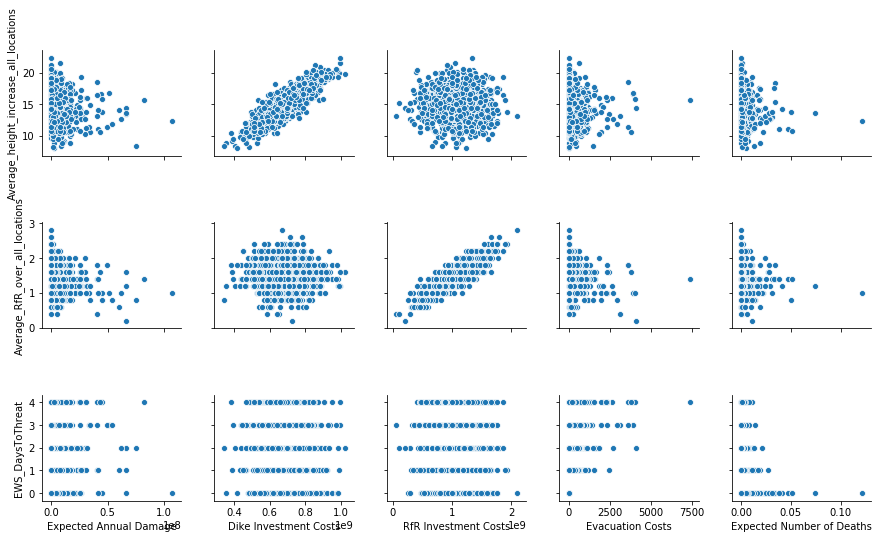

In [148]:
sns.pairplot(pd.DataFrame.from_dict(aggregated_df),  x_vars=['Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'], y_vars=['Average_height_increase_all_locations',
       'Average_RfR_over_all_locations', 'EWS_DaysToThreat'])
plt.show()

Index(['Unnamed: 0', 'discount rate 0', 'discount rate 1', 'discount rate 2',
       'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate',
       'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail',
       'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax',
       'A.5_pfail', 'A.5_Brate', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model'],
      dtype='object')

In [ ]:
#for lever in model.levers:
#   print(lever.name)

In [ ]:
#for unc in model.uncertainties:
 #   print(repr(unc))

In [ ]:
#for outcome in model.outcomes:
 #   print(repr(outcome))

[MainProcess/INFO] performing 2 scenarios * 2 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished


<class 'ema_workbench.em_framework.outcomes.ScalarOutcome'>
<class 'ema_workbench.em_framework.outcomes.ScalarOutcome'>
<class 'ema_workbench.em_framework.outcomes.ScalarOutcome'>


array(['A.1', 'A.2', 'A.3', 'A.4', 'A.5'], dtype=object)

[MainProcess/INFO] no time dimension found in results


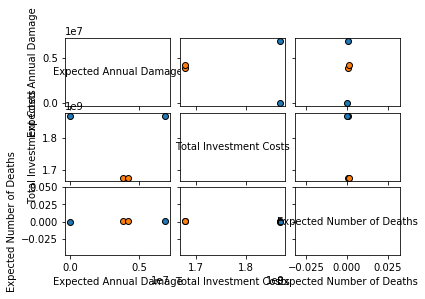